In [1]:
#Script for examining results of model

In [44]:
import os
from pathlib import Path

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import kaiming_uniform_

import scipy
from scipy.stats.qmc import Sobol

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
plotly.io.defaults.mathjax = "https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"
pio.renderers.default = 'iframe'

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors

In [3]:
DEVICE = torch.device(os.getenv('OP_DEVICE', 'cuda' if torch.cuda.is_available() else 'cpu'))
DTYPE  = torch.float64

In [5]:
weight = 0.7
neg_weight = 10.0
batch_size = 128

layers = [50, 50, 50]
seed = 33

In [6]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [7]:
# -----------------------------------------------------------------------------
#  Hard‑wired model parameters
# -----------------------------------------------------------------------------
crra = 5.0
beta = 0.9
alpha = 0.5

psi = 7.08
pi_star = 1.0484

rho_y = 0.8118
eta = 0.0347
sigma_y = eta/np.sqrt(1.0 - (rho_y ** 2.0))

mu = 0.0
y_ubnd = mu + 3.0 * sigma_y
y_lbnd = mu - 3.0 * sigma_y

b_star_ubnd = 0.3
b_star_lbnd = -0.1

b_tilde_ubnd = 0.3
b_tilde_lbnd = -0.1

kappa = 40.0

r = 0.039
R = np.exp(r)
delta = 0.757

qstar = 1.0 / (R - delta)

EPS = 1e-12

In [8]:
path = ''
base_path = f'{path}/pickle/kappa{kappa}'

In [9]:
#n_int sets the number of nodes in the Gauss-Hermite quadrature used to approximate expectations
n_int = 19

x_int_norm, w_int = np.polynomial.hermite.hermgauss(n_int)
w_int = w_int/np.sqrt(np.pi)
x_int_norm = x_int_norm * np.sqrt(2)

w_int = torch.from_numpy(w_int).to(DEVICE)
x_int_norm = torch.from_numpy(x_int_norm).to(DEVICE)

innovation_i = x_int_norm.view(1, n_int, 1)
weight_i = w_int.view(1, n_int, 1)

In [10]:
class NN_pi(nn.Module):
    def __init__(self, in_szs, out_szs, layers):
        super().__init__()

        layerlist = []
        n_in = in_szs
        
        for i in layers:
            kaiming_uniform_(nn.Linear(n_in, i).weight, nonlinearity='leaky_relu')
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.LeakyReLU())
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))
        layerlist.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*layerlist)
                
    def forward(self, x):
        
        pred = self.layers(x)
        
        pred = pred * (1.1 - 1.0) + 1.0
                    
        return pred

In [11]:
class NN_foreign(nn.Module):
    def __init__(self, in_szs, out_szs, layers):
        super().__init__()

        layerlist = []
        n_in = in_szs
        
        for i in layers:
            kaiming_uniform_(nn.Linear(n_in, i).weight, nonlinearity='leaky_relu')
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.LeakyReLU())
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))
        layerlist.append(nn.Identity())
        
        self.layers = nn.Sequential(*layerlist)
                
    def forward(self, x):
        
        pred = self.layers(x)
                    
        return pred

In [12]:
class NN_local(nn.Module):
    def __init__(self, in_szs, out_szs, layers):
        super().__init__()

        layerlist = []
        n_in = in_szs
        
        for i in layers:
            kaiming_uniform_(nn.Linear(n_in, i).weight, nonlinearity='leaky_relu')
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.LeakyReLU())
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))
        layerlist.append(nn.Identity())
        
        self.layers = nn.Sequential(*layerlist)
                
    def forward(self, x):
        
        pred = self.layers(x)
                    
        return pred

In [13]:
class NN_val(nn.Module):
    def __init__(self, in_szs, out_szs, layers):
        super().__init__()

        layerlist = []
        n_in = in_szs
        
        for i in layers:
            kaiming_uniform_(nn.Linear(n_in, i).weight, nonlinearity='leaky_relu')
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.LeakyReLU())
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))
        layerlist.append(nn.Identity())
        
        self.layers = nn.Sequential(*layerlist)
                
    def forward(self, x):
        
        pred = self.layers(x)
                    
        return pred

In [14]:
class NN_qtilde(nn.Module):
    def __init__(self, in_szs, out_szs, layers):
        super().__init__()

        layerlist = []
        n_in = in_szs
        
        for i in layers:
            kaiming_uniform_(nn.Linear(n_in, i).weight, nonlinearity='leaky_relu')
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.LeakyReLU())
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))
        layerlist.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*layerlist)
                
    def forward(self, x):
        
        pred = self.layers(x)
        
        pred = pred * 10.0
                            
        return pred

In [15]:
class NN_q(nn.Module):
    def __init__(self, in_szs, out_szs, layers):
        super().__init__()

        layerlist = []
        n_in = in_szs
        
        for i in layers:
            kaiming_uniform_(nn.Linear(n_in, i).weight, nonlinearity='leaky_relu')
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.LeakyReLU())
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))
        layerlist.append(nn.Softplus())
        
        self.layers = nn.Sequential(*layerlist)
                
    def forward(self, x):
        
        pred = self.layers(x)
                                    
        return pred

In [16]:
def compute_error(X, nn_pi, nn_foreign, nn_local, nn_val, nn_qtilde, nn_q):
        
    n_data = X.shape[0]
    
    yt = X[:, 0:1]
    bstar = X[:, 1:2]
    btilde = X[:, 2:3]
    
    pi = nn_pi(X)
    bstar_prime = nn_foreign(X)
    btilde_prime = nn_local(X)
    val = nn_val(X)
        
    exp_sdf = torch.zeros((n_data, 1)).to(DEVICE)
    exp_r   = torch.zeros((n_data, 1)).to(DEVICE)
    exp_q   = torch.zeros((n_data, 1)).to(DEVICE)
    
    exp_sdf_r = torch.zeros((n_data, 1)).to(DEVICE)
    exp_sdf_q = torch.zeros((n_data, 1)).to(DEVICE)
    exp_r_q   = torch.zeros((n_data, 1)).to(DEVICE)
    
    exp_q_rest = torch.zeros((n_data, 1)).to(DEVICE)
    
    exp_val_prime = torch.zeros((n_data, 1)).to(DEVICE)
    exp_qtilde_inside = torch.zeros((n_data, 1)).to(DEVICE)
    
    exp_dval_prime_dbstar_prime = torch.zeros((n_data, 1)).to(DEVICE)
    exp_dval_prime_dbtilde_prime = torch.zeros((n_data, 1)).to(DEVICE)
    
    exp_dqtilde_dbstar_prime_inside = torch.zeros((n_data, 1)).to(DEVICE)
    exp_dqtilde_dbtilde_prime_inside = torch.zeros((n_data, 1)).to(DEVICE)
    
    # ------------------------------------------------------------------
    # Compute expectation terms using vectorized code
    # ------------------------------------------------------------------
    #Below B is the batch size, so like 64 or 128 or 256
    yt_b = yt[:,None]     # (B,1,1)
    
    m = torch.exp(-r - kappa * innovation_i * eta - 0.5 * (kappa ** 2.0) * (eta ** 2.0))
    
    yt_prime = torch.exp(rho_y * torch.log(yt_b) + innovation_i * eta)
    
    yt_prime = yt_prime.expand(-1, n_int, -1) # (B, n_int, 1)
    m = m.expand(-1, n_int, -1)
    
    bstar_p = bstar_prime.unsqueeze(1)
    btilde_p = btilde_prime.unsqueeze(1)
    
    bstar_p = bstar_p.expand(-1, n_int, -1)
    btilde_p = btilde_p.expand(-1, n_int, -1)
    
    X_prime = torch.cat((yt_prime, bstar_p, btilde_p), dim = -1)
    X_prime_flat = X_prime.reshape(-1, 3)  # (B*11 , 3)
    
    val_prime, qtilde_inside, dval_prime_dbstar_prime, dval_prime_dbtilde_prime, dqtilde_dbstar_prime_inside, dqtilde_dbtilde_prime_inside = get_exp_prime(X_prime_flat, nn_pi, nn_foreign, nn_local, nn_val, nn_qtilde, nn_q)

    val_prime = val_prime.view(n_data, n_int, 1)
    qtilde_inside = qtilde_inside.view(n_data, n_int, 1)
    
    dval_prime_dbstar_prime = dval_prime_dbstar_prime.view(n_data, n_int, 1)
    dval_prime_dbtilde_prime = dval_prime_dbtilde_prime.view(n_data, n_int, 1)
    
    dqtilde_dbstar_prime_inside = dqtilde_dbstar_prime_inside.view(n_data, n_int, 1)
    dqtilde_dbtilde_prime_inside = dqtilde_dbtilde_prime_inside.view(n_data, n_int, 1)
    
    exp_val_prime = (weight_i * val_prime).sum(1)
    exp_qtilde_inside = (weight_i * m * qtilde_inside).sum(1)
    
    exp_dval_prime_dbstar_prime = (weight_i * dval_prime_dbstar_prime).sum(1)
    exp_dval_prime_dbtilde_prime = (weight_i * dval_prime_dbtilde_prime).sum(1)
    
    exp_dqtilde_dbstar_prime_inside = (weight_i * m * dqtilde_dbstar_prime_inside).sum(1)
    exp_dqtilde_dbtilde_prime_inside = (weight_i * m * dqtilde_dbtilde_prime_inside).sum(1)

    # ------------------------------------------------------------------
    # Use expectations to construct error terms
    # ------------------------------------------------------------------
        
    qtilde = exp_qtilde_inside
    dqtilde_dbstar_prime = exp_dqtilde_dbstar_prime_inside
    dqtilde_dbtilde_prime = exp_dqtilde_dbtilde_prime_inside
    
    ct_discriminant = ((btilde / pi) ** 2.0) - 4.0 * (bstar - qstar * (bstar_prime - delta * bstar) - qtilde * (btilde_prime - delta * (btilde / pi)) - yt)
    ct_discriminant_clamped = torch.clamp(ct_discriminant, min = EPS)
    numerator = (-btilde / pi) + (ct_discriminant_clamped ** 0.5)
    ct = 0.25 * (numerator ** 2.0)
        
    zeta = (1.0 / pi) * (ct ** (1.0 - alpha))
    zeta_one = ct ** (1.0 - alpha)
    dzeta_dpi = -(1.0 / (pi ** 2.0)) * (ct ** (1.0 - alpha))
    dzeta_dct = (1.0 - alpha) * (1.0 / pi) * (ct ** -alpha)
    
    c = ct ** alpha
    lambda_ct_numerator = (1.0 - beta) * (c ** -crra) * alpha * (ct ** (alpha - 1.0))
    lambda_ct_denominator = 1.0 + dzeta_dct * btilde
    lambda_ct = lambda_ct_numerator / lambda_ct_denominator
    
    lambda_pi_numerator = (1.0 - beta) * psi * (pi - pi_star)
    lambda_pi_denominator = (btilde / (pi ** 2.0)) * (ct ** (1.0 - alpha)) + delta * (btilde / (pi ** 2.0)) * qtilde
    lambda_pi = lambda_pi_numerator / lambda_pi_denominator
    
    xr = alpha * pi * (ct ** (alpha - 1.0))
    
    q = (1.0 / zeta_one) * qtilde
    
    qtilde_pred = nn_qtilde(X)
    q_pred = nn_q(X)
    
    qtilde_detached = qtilde.detach()
    q_detached = q.detach()
        
    err_qtilde = qtilde_detached - qtilde_pred
    
    err_q = q_detached - q_pred
    
    err_val = (1.0 - beta) * (((c ** (1.0 - crra)) / (1.0 - crra)) - (psi / 2.0) * ((pi - pi_star) ** 2.0)) + beta * exp_val_prime - val
    
    errREE_c_pi = lambda_ct - lambda_pi
    
    errREE_bstar = lambda_ct * (qstar + dqtilde_dbstar_prime * (btilde_prime - delta * (btilde / pi))) + beta * exp_dval_prime_dbstar_prime
    
    errREE_btilde = lambda_ct * (qtilde + dqtilde_dbtilde_prime * (btilde_prime - delta * (btilde / pi))) + beta * exp_dval_prime_dbtilde_prime
    
    err_discriminant = torch.clamp(-ct_discriminant, min = 0.0)
    
    err_numerator = torch.clamp(-numerator, min = 0.0)
    
    return (err_val, errREE_c_pi, errREE_bstar, errREE_btilde, err_qtilde, err_q, 
            err_discriminant, err_numerator, qtilde, q, bstar_prime, btilde_prime, val, pi, xr)
    

In [17]:
def get_exp_prime(X_prime, nn_pi, nn_foreign, nn_local, nn_val, nn_qtilde, nn_q):
        
    n_data = X_prime.shape[0]
    
    yt_prime = X_prime[:, 0:1]
    bstar_prime = X_prime[:, 1:2]
    btilde_prime = X_prime[:, 2:3]
    
    pi_prime = nn_pi(X_prime)
    bstar_prime_next = nn_foreign(X_prime)
    btilde_prime_next = nn_local(X_prime)
    val_prime = nn_val(X_prime)
        
    qtilde_prime = nn_qtilde(X_prime)
    q_prime = nn_q(X_prime)
    
    ct_discriminant_prime = ((btilde_prime / pi_prime) ** 2.0) - 4.0 * (bstar_prime - qstar * (bstar_prime_next - delta * bstar_prime) - qtilde_prime * (btilde_prime_next - delta * (btilde_prime / pi_prime)) - yt_prime)
    ct_discriminant_prime_clamped = torch.clamp(ct_discriminant_prime, min = EPS)
    ct_prime = 0.25 * (((-btilde_prime / pi_prime) + (ct_discriminant_prime_clamped ** 0.5)) ** 2.0)
    
    zeta_prime = (1.0 / pi_prime) * (ct_prime ** (1.0 - alpha))
    dzeta_prime_dpi_prime = -(1.0 / (pi_prime ** 2.0)) * (ct_prime ** (1.0 - alpha))
    dzeta_prime_dct_prime = (1.0 - alpha) * (1.0 / pi_prime) * (ct_prime ** -alpha)
    
    qtilde_inside = zeta_prime * (1.0 + delta * q_prime)
    
    c_prime = ct_prime ** alpha
    lambda_ct_prime_numerator = (1.0 - beta) * (c_prime ** -crra) * alpha * (ct_prime ** (alpha - 1.0))
    lambda_ct_prime_denominator = 1.0 + dzeta_prime_dct_prime * btilde_prime
    lambda_ct_prime = lambda_ct_prime_numerator / lambda_ct_prime_denominator
    
    dval_prime_dbstar_prime = -lambda_ct_prime * (1.0 + qstar * delta)
    dval_prime_dbtilde_prime = -lambda_ct_prime * (zeta_prime + qtilde_prime * delta * (1.0 / pi_prime))
    
    (dct_prime_dbstar_prime, dct_prime_dbtilde_prime, dpi_prime_dbstar_prime, 
     dpi_prime_dbtilde_prime, dq_prime_dbstar_prime, dq_prime_dbtilde_prime) = get_autograd_derivative(X_prime, nn_pi, nn_foreign, nn_local, nn_qtilde, nn_q)
    
    dqtilde_dbstar_prime_inside = (dzeta_prime_dpi_prime * dpi_prime_dbstar_prime + dzeta_prime_dct_prime * dct_prime_dbstar_prime) * (1.0 + delta * q_prime) + zeta_prime * delta * dq_prime_dbstar_prime
    dqtilde_dbtilde_prime_inside = (dzeta_prime_dpi_prime * dpi_prime_dbtilde_prime + dzeta_prime_dct_prime * dct_prime_dbtilde_prime) * (1.0 + delta * q_prime) + zeta_prime * delta * dq_prime_dbtilde_prime
    
    return val_prime, qtilde_inside, dval_prime_dbstar_prime, dval_prime_dbtilde_prime, dqtilde_dbstar_prime_inside, dqtilde_dbtilde_prime_inside
    

In [18]:
def get_autograd_derivative(X_prime, nn_pi, nn_foreign, nn_local, nn_qtilde, nn_q):
        
    X_prime_auto = X_prime.detach().clone().requires_grad_(True)
    
    yt_prime_auto = X_prime_auto[:, 0:1]
    bstar_prime_auto = X_prime_auto[:, 1:2]
    btilde_prime_auto = X_prime_auto[:, 2:3]
    
    pi_prime_auto = nn_pi(X_prime_auto)
    bstar_prime_next_auto = nn_foreign(X_prime_auto)
    btilde_prime_next_auto = nn_local(X_prime_auto)
    qtilde_prime_auto = nn_qtilde(X_prime_auto)
    q_prime_auto = nn_q(X_prime_auto)
    
    ct_discriminant_prime_auto = ((btilde_prime_auto / pi_prime_auto) ** 2.0) - 4.0 * (bstar_prime_auto - qstar * (bstar_prime_next_auto - delta * bstar_prime_auto) - qtilde_prime_auto * (btilde_prime_next_auto - delta * (btilde_prime_auto / pi_prime_auto)) - yt_prime_auto)
    ct_discriminant_prime_auto_clamped = torch.clamp(ct_discriminant_prime_auto, min = EPS)
    numerator_prime_auto = (-btilde_prime_auto / pi_prime_auto) + torch.sqrt(ct_discriminant_prime_auto_clamped)
    ct_prime_auto = 0.25 * (numerator_prime_auto ** 2.0)
    
    ct_grads = torch.autograd.grad(
    outputs=ct_prime_auto,                      # shape (n_data, 1)
    inputs=X_prime_auto,             # shape (n_data, 4)
    grad_outputs=torch.ones_like(ct_prime_auto),  # each row's derivative
    create_graph=True,)[0]
    
    #Compute the derivatives of ct_prime
    dct_prime_dbstar_prime = ct_grads[:, 1:2]
    dct_prime_dbtilde_prime = ct_grads[:, 2:3]
    
    pi_grads = torch.autograd.grad(
    outputs=pi_prime_auto,                      # shape (n_data, 1)
    inputs=X_prime_auto,             # shape (n_data, 3)
    grad_outputs=torch.ones_like(pi_prime_auto),  # each row's derivative
    create_graph=True,)[0]
    
    #Compute the derivatives of pi_prime
    dpi_prime_dbstar_prime = pi_grads[:, 1:2]
    dpi_prime_dbtilde_prime = pi_grads[:, 2:3]                   # shape (n_data, 1)
    
    q_grads = torch.autograd.grad(
    outputs=q_prime_auto,                      # shape (n_data, 1)
    inputs=X_prime_auto,             # shape (n_data, 3)
    grad_outputs=torch.ones_like(q_prime_auto),  # each row's derivative
    create_graph=True,)[0]
    
    #Compute the derivatives of q_prime
    dq_prime_dbstar_prime = q_grads[:, 1:2]
    dq_prime_dbtilde_prime = q_grads[:, 2:3]

    
    return dct_prime_dbstar_prime, dct_prime_dbtilde_prime, dpi_prime_dbstar_prime, dpi_prime_dbtilde_prime, dq_prime_dbstar_prime, dq_prime_dbtilde_prime
    

In [19]:
new_model_pi = NN_pi(3, 1, layers)
new_model_pi.load_state_dict(torch.load(f'{base_path}_Model_pi.pt', map_location=DEVICE))
new_model_pi = new_model_pi.to(device=DEVICE, dtype=torch.float64).to(DEVICE)
new_model_pi.eval()

NN_pi(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [20]:

new_model_foreign = NN_foreign(3, 1, layers)
new_model_foreign.load_state_dict(torch.load(f'{base_path}_Model_foreign.pt', map_location=DEVICE))
new_model_foreign = new_model_foreign.to(device=DEVICE, dtype=torch.float64).to(DEVICE)
new_model_foreign.eval()

NN_foreign(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Identity()
  )
)

In [21]:
new_model_local = NN_local(3, 1, layers)
new_model_local.load_state_dict(torch.load(f'{base_path}_Model_local.pt', map_location=DEVICE))
new_model_local = new_model_local.to(device=DEVICE, dtype=torch.float64).to(DEVICE)
new_model_local.eval()

NN_local(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Identity()
  )
)

In [22]:
new_model_val = NN_val(3, 1, layers)
new_model_val.load_state_dict(torch.load(f'{base_path}_Model_val.pt', map_location=DEVICE))
new_model_val = new_model_val.to(device=DEVICE, dtype=torch.float64).to(DEVICE)
new_model_val.eval()

NN_val(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Identity()
  )
)

In [23]:
new_model_qtilde = NN_qtilde(3, 1, layers)
new_model_qtilde.load_state_dict(torch.load(f'{base_path}_Model_qtilde.pt', map_location=DEVICE))
new_model_qtilde = new_model_qtilde.to(device=DEVICE, dtype=torch.float64).to(DEVICE)
new_model_qtilde.eval()

NN_qtilde(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [24]:
new_model_q = NN_q(3, 1, layers)
new_model_q.load_state_dict(torch.load(f'{base_path}_Model_q.pt', map_location=DEVICE))
new_model_q = new_model_q.to(device=DEVICE, dtype=torch.float64).to(DEVICE)
new_model_q.eval()

NN_q(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Softplus(beta=1, threshold=20)
  )
)

In [25]:
def full_grid_minibatch(full_grid, 
                        mini_batch_size, 
                        nn_pi, nn_foreign, nn_local, nn_val, nn_qtilde, nn_q):
    
    # ---- lists to collect errors (add/remove as you need) ----
    err_val_list        = []
    err_cpi_list        = []
    err_bstar_list      = []
    err_btilde_list     = []
    err_qtilde_list     = []
    err_q_list          = []
    err_disc_list       = []
    err_num_list        = []
    
    # ---- lists to collect objects you need over the whole grid ----
    qtilde_list         = []
    q_list              = []
    bstar_prime_list    = []
    btilde_prime_list   = []
    val_list            = []
    pi_list             = []
    xr_list             = []
    
    N = full_grid.shape[0]
    
    start = 0
    while start < N:
        end = min(start + mini_batch_size, N)
        Xb = full_grid[start:end]
        

        (err_val, errREE_c_pi, errREE_bstar, errREE_btilde, err_qtilde, 
         err_q, err_discriminant, err_numerator, qtilde, q, bstar_prime, 
         btilde_prime, val, pi, xr) = compute_error(Xb, nn_pi, nn_foreign, nn_local, nn_val, nn_qtilde, nn_q)

        #Append elements of loss term
        err_val_list.append(       err_val.detach().cpu().numpy() )
        err_cpi_list.append(       errREE_c_pi.detach().cpu().numpy() )
        err_bstar_list.append(     errREE_bstar.detach().cpu().numpy() )
        err_btilde_list.append(    errREE_btilde.detach().cpu().numpy() )
        err_qtilde_list.append(    err_qtilde.detach().cpu().numpy() )
        err_q_list.append(         err_q.detach().cpu().numpy() )
        err_disc_list.append(      err_discriminant.detach().cpu().numpy() )
        err_num_list.append(       err_numerator.detach().cpu().numpy() )
        
        #Append objects for plotting 
        qtilde_list.append(        qtilde.detach().cpu().numpy() )
        q_list.append(             q.detach().cpu().numpy() )
        bstar_prime_list.append(   bstar_prime.detach().cpu().numpy() )
        btilde_prime_list.append(  btilde_prime.detach().cpu().numpy() )
        val_list.append(           val.detach().cpu().numpy() )
        pi_list.append(            pi.detach().cpu().numpy() )
        xr_list.append(            xr.detach().cpu().numpy() )
        
        del Xb, err_val, errREE_c_pi, errREE_bstar, errREE_btilde, err_qtilde, err_q
        del qtilde, q, bstar_prime, btilde_prime, val, pi
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        start = end
        
    def _stack(lst):
        
        arr = np.concatenate(lst, axis=0)
        
        return arr

    results = {
        # errors over the full grid
        "err_val":       _stack(err_val_list),
        "errREE_cpi":    _stack(err_cpi_list),
        "errREE_bstar":  _stack(err_bstar_list),
        "errREE_btilde": _stack(err_btilde_list),
        "err_qtilde":    _stack(err_qtilde_list),
        "err_q":         _stack(err_q_list),
        "err_disc":      _stack(err_disc_list),
        "err_num":       _stack(err_num_list),
        # "err_discriminant": _stack(err_discriminant_list),
        # "err_numerator":    _stack(err_numerator_list),

        # objects over the full grid
        "qtilde":        _stack(qtilde_list),
        "q":             _stack(q_list),
        "bstar_prime":   _stack(bstar_prime_list),
        "btilde_prime":  _stack(btilde_prime_list),
        "val":           _stack(val_list),
        "pi":            _stack(pi_list),
        "xr":            _stack(xr_list)
    }
    
    
    return results


In [26]:
#Construct a grid with n_data nodes per state dimension. Nodes are evenly spaced over the domain of each state
n_data = 16

y_t_grid_log = torch.linspace(y_lbnd, y_ubnd, n_data)
y_t_grid = torch.exp(y_t_grid_log)
y_t_grid = y_t_grid.view(n_data, 1).to(DEVICE)
y_t_grid.shape

torch.Size([16, 1])

In [27]:
bstar_grid = torch.linspace(b_star_lbnd, b_star_ubnd, n_data)
bstar_grid = bstar_grid.view(n_data, 1).to(DEVICE)
bstar_grid.shape

torch.Size([16, 1])

In [28]:
btilde_grid = torch.linspace(b_tilde_lbnd, b_tilde_ubnd, n_data)
btilde_grid = btilde_grid.view(n_data, 1).to(DEVICE)
btilde_grid.shape

torch.Size([16, 1])

In [29]:
num_data = y_t_grid.shape[0]
num_data2 = y_t_grid.shape[0] * bstar_grid.shape[0]
total_data = y_t_grid.shape[0] * bstar_grid.shape[0] * btilde_grid.shape[0]

full_tilde_grid = torch.zeros(total_data, 3)

for i in range(num_data):
    full_tilde_grid[i*num_data2 : (i+1)*num_data2, 0 : 1] = y_t_grid[i]
    for j in range(num_data):
        full_tilde_grid[i*num_data2 + j*num_data : i*num_data2 + (j+1)*num_data , 1 : 2] = bstar_grid[j]
        for k in range(num_data):
            full_tilde_grid[i*num_data2 + j*num_data + k, 2 : 3] = btilde_grid[k]
        
full_tilde_grid = full_tilde_grid.to(device=DEVICE, dtype=torch.float64).to(DEVICE)

In [30]:
mini_batch_size = full_tilde_grid.shape[0] // 64

output = full_grid_minibatch(full_tilde_grid, 
                             mini_batch_size, 
                             new_model_pi, new_model_foreign, new_model_local, new_model_val, new_model_qtilde, new_model_q)

In [31]:
w_neg = neg_weight
w_val = weight
w_ERR = (1.0 - weight) / 5.0

loss = w_ERR * np.mean(output["errREE_cpi"] ** 2) + w_ERR * np.mean(output["errREE_bstar"] ** 2) + w_ERR * np.mean(output["errREE_btilde"] ** 2) + w_ERR * np.mean(output["err_qtilde"] ** 2) + w_ERR * np.mean(output["err_q"] ** 2) + w_val * np.mean(output["err_val"] ** 2) + w_neg * np.mean(output["err_disc"] ** 2) + w_neg * np.mean(output["err_num"] ** 2)    


In [32]:
print(f'Avg loss = {loss}')
print(f'Value func MSE = {np.mean(output["err_val"] ** 2)}')
print(f'Consumption MSE = {np.mean(output["errREE_cpi"] ** 2)}')
print(f'FC debt MSE = {np.mean(output["errREE_bstar"] ** 2)}')
print(f'LC debt MSE = {np.mean(output["errREE_btilde"] ** 2)}')
print(f'LC debt price MSE = {np.mean(output["err_q"] ** 2)}')
print(f'Detrended LC debt price MSE = {np.mean(output["err_qtilde"] ** 2)}')

Avg loss = 4.026521283744045e+39
Value func MSE = 1.7270792759073888e+28
Consumption MSE = 2.9138668006664505e+39
FC debt MSE = 5.062204586655421e+40
LC debt MSE = 1.3572775394978585e+40
LC debt price MSE = 257513.48059181482
Detrended LC debt price MSE = 13.69203946363302


In [33]:
n_data = num_data
n_data2 = num_data2

In [34]:
full_tilde_grid = full_tilde_grid.cpu().detach().numpy()
btilde_grid = full_tilde_grid[:, 2].reshape(n_data, n_data, n_data)
y_grid = full_tilde_grid[:, 0].reshape(n_data, n_data, n_data)

y_levels = y_grid[:, 0, 0]

In [42]:
bstar_index_mid  = n_data // 2

In [45]:
# -----------------------------------------------------------------------------
#  Plot figures from model solution
# -----------------------------------------------------------------------------
base = Path(path or ".").expanduser().resolve() 
fig_dir = base / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

In [46]:
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 10,
    "axes.titlesize": 12,
    "pdf.fonttype": 42,
    "svg.fonttype": "none",
})

In [47]:
def setup_plotly_pubstyle():
    # Times New Roman if available; otherwise fall back to free look-alikes.
    font_stack = "Times New Roman, Times, Liberation Serif, Nimbus Roman, TeX Gyre Termes, serif"

    pio.templates["pub"] = go.layout.Template(
        layout=dict(
            # global font
            font=dict(family=font_stack, size=12),
            title=dict(font=dict(size=20)),
            legend=dict(font=dict(size=12), orientation="h", x=0, y=1.02, borderwidth=0),
            paper_bgcolor="white",
            plot_bgcolor="#efefef",
            margin=dict(l=80, r=20, t=60, b=60),

            # axes style (mirrored spines, outside ticks, light grid)
            xaxis=dict(
                zeroline = False,
                title_font=dict(size=16),
                tickfont=dict(size=14),
                showline=True, mirror=True, linewidth=1, linecolor="white",
                ticks="outside", tickwidth=1, tickcolor="white",
                showgrid=True, gridcolor="rgba(0,0,0,0.12)"
            ),
            yaxis=dict(
                zeroline = False,
                title_font=dict(size=16),
                tickfont=dict(size=14),
                showline=True, mirror=True, linewidth=1, linecolor="white",
                ticks="outside", tickwidth=1, tickcolor="white",
                showgrid=True, gridcolor="rgba(0,0,0,0.12)"
            ),

            # optional: a restrained color cycle
            colorway=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b"]
        )
    )

    # make it the default for this session
    pio.templates.default = "pub"

    # sensible export defaults (vector by default)
    plotly.io.defaults.default_format = "pdf"   # or "svg"/"png"
    plotly.io.defaults.default_width  = 800
    plotly.io.defaults.default_height = 600
    # keep MathJax on so LaTeX in titles/labels renders in static exports
    plotly.io.defaults.mathjax = "cdn"

In [55]:
def plot_panel(bstar_idx, title, ylabel, pol):
    
    savepath = pol
    
    color_map = mpl.colormaps.get_cmap('viridis')
    #Normalize the color map so that each line is assignd a uniqu color btween 0 
    # and 1, so that u = y - y_min / (y_max - y_min) withc is between [0,1]
    norm = mcolors.Normalize(vmin = y_levels.min(), vmax = y_levels.max())
    sm = cm.ScalarMappable(norm = norm, cmap = color_map); sm.set_array([])    
    
    pol_arr = output[pol][:, 0].reshape(n_data, n_data, n_data)
    
    fig, ax = plt.subplots()
    
    for i in range(n_data):
        
        x = btilde_grid[0, 0, :]
        y = pol_arr[i, bstar_idx, :]
        ax.plot(x, y, color = color_map(norm(y_levels[i])))
        
    plt.title(title)
    plt.xlabel('LC Bonds')
    plt.ylabel(ylabel)
    cbar = plt.colorbar(sm, pad = 0.01, ax = ax)
    #Inverts the colormap key title on the RHS of the plot. Makes it easier to read
    cbar.ax.set_ylabel('Tradable Output', rotation=-90, va="bottom")
    
    fig.tight_layout()
    fig.savefig(fig_dir / f"{pol}.png", dpi=300, bbox_inches="tight")
    

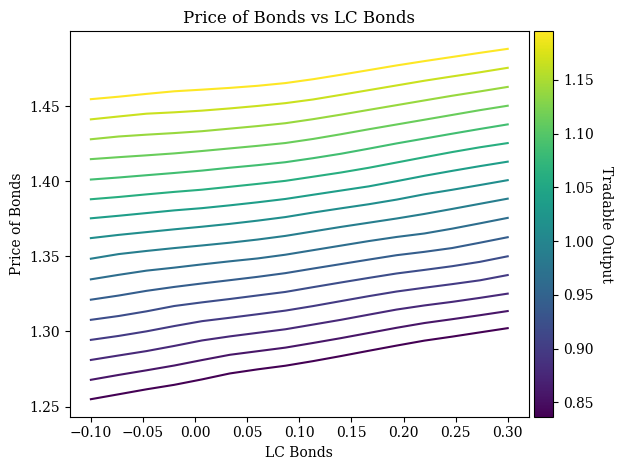

In [56]:
plot_panel(bstar_index_mid, "Price of Bonds vs LC Bonds", "Price of Bonds", "qtilde")

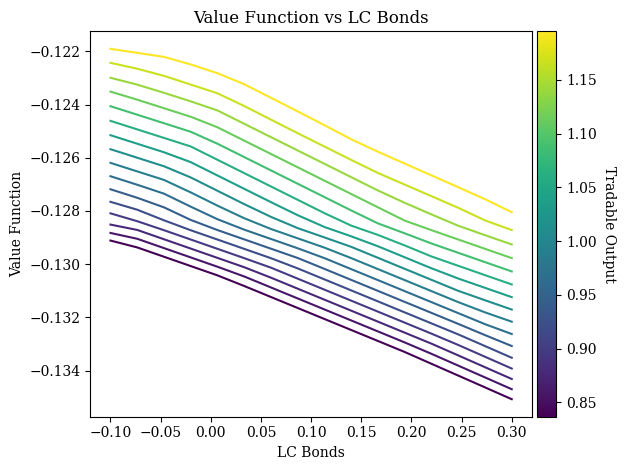

In [58]:
plot_panel(bstar_index_mid, "Value Function vs LC Bonds", "Value Function", "val")

In [51]:
y_index = np.int64(n_data / 2)

fig = go.Figure(data=go.Scatter(
    x = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 1],
    y = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 2],
    mode='markers',
    marker=dict(
        size=9,
        color = output["qtilde"][y_index * n_data2 : (y_index + 1) * n_data2, 0], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True,
        colorbar=dict(
                title="LC Bond Price",        # ← colorbar title
                title_side="right"         # optional: 'right', 'top', 'bottom'
            ),
    )
))

fig.update_layout(
    title="LC Bond Price vs. LC Bonds and FC bonds - Middle Income",
    xaxis_title="LC Bonds",
    yaxis_title="FC Bonds",)

fig.show()

fig.write_image(fig_dir / "LCBond_price.png")

In [61]:
y_index = np.int64(n_data / 2)

fig = go.Figure(data=go.Scatter(
    x = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 1],
    y = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 2],
    mode='markers',
    marker=dict(
        size=9,
        color = output["btilde_prime"][y_index * n_data2 : (y_index + 1) * n_data2, 0], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True,
        colorbar=dict(
                title="Issued LC Bonds",        # ← colorbar title
                title_side="right"        # optional: 'right', 'top', 'bottom'
            ),
    )
))

fig.update_layout(
    title="Issued LC Bonds vs. Outstanding LC Bonds and FC Bonds - Middle Income",
    xaxis_title="LC Bonds",
    yaxis_title="FC Bonds",)

fig.show()
fig.write_image(fig_dir / "LCBond_issuance.png")

In [59]:
y_index = np.int64(n_data / 2)

fig = go.Figure(data=go.Scatter(
    x = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 1],
    y = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 2],
    mode='markers',
    marker=dict(
        size=9,
        color = output["bstar_prime"][y_index * n_data2 : (y_index + 1) * n_data2, 0], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True,
        colorbar=dict(
                title="Issued FC Bonds",        # ← colorbar title
                title_side="right"        # optional: 'right', 'top', 'bottom'
            ),
    )
))

fig.update_layout(
    title="Issued FC Bonds vs. Outstanding LC Bonds and FC Bonds - Middle Income",
    xaxis_title="LC Bonds",
    yaxis_title="FC Bonds",)

fig.show()
fig.write_image(fig_dir / "FCBond_issuance.png")

In [52]:
y_index = np.int64(n_data / 2)

fig = go.Figure(data=go.Scatter(
    x = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 1],
    y = full_tilde_grid[y_index * n_data2 : (y_index + 1) * n_data2, 2],
    mode='markers',
    marker=dict(
        size=9,
        color = output["xr"][y_index * n_data2 : (y_index + 1) * n_data2, 0], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True,
        colorbar=dict(
                title="Exchange Rate",        # ← colorbar title
                title_side="right"        # optional: 'right', 'top', 'bottom'
            ),
    )
))

fig.update_layout(
    title="Exchange Rate vs. Outstanding LC Bonds and FC Bonds - Middle Income",
    xaxis_title="LC Bonds",
    yaxis_title="FC Bonds",)

fig.show()
fig.write_image(fig_dir / "ExchangeRate.png")